In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional,GlobalMaxPooling1D
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-06-30 23:02:41.956266: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-30 23:02:43.341659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-30 23:02:43.341715: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

### Loading the Full prepared dataset - Fakeddit

In [2]:
final_df=pd.read_csv("Updated//fakeddit_full_valid_cleaned_comment_using_nltk.csv")
final_df=final_df.dropna()
final_df = final_df.sample(frac = 1)

#### Splitting Data into Train and Test Datasets

In [3]:
train, test = train_test_split(final_df[['fulltext','class']], test_size=0.3,stratify=final_df['class'], random_state=0)

###### Due to huge data size and memory constraaint issues, here we are considering 1 lakh records for training part with 50k each for fake and news category

In [4]:
train_fake=train[train['class']==1].iloc[0:50000]
train_real=train[train['class']==0].iloc[0:50000]

# Concating the 2 dataframes for training part
train_merged=pd.concat([train_fake,train_real],axis=0)

# Shuffling the rows
train_sampled = train_merged.sample(frac=1)
test_sampled = test.sample(frac=.5)

In [5]:
X_train=train_sampled['fulltext']
y_train=train_sampled['class']
X_test=test_sampled['fulltext']
y_test=test_sampled['class']

### Using TFIDF Tokenisation mode

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features = 3000

tokenizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 1),
                       tokenizer=nltk.word_tokenize,
                       strip_accents='unicode',
                       lowercase=True, analyzer='word', token_pattern=r'\w+',
                       use_idf=True, smooth_idf=True, sublinear_tf=False)

In [8]:
# Fit & Transform on train texts
# Only transform on val & test texts

x_train_tf = tokenizer.fit_transform(X_train).toarray()
x_test_tf = tokenizer.transform(X_test).toarray()

In [9]:
# Printing the shape of different text corpus

print('x_train_tf shape: ', x_train_tf.shape)
print('x_test_tf: ', x_test_tf.shape)

x_train_tf shape:  (100000, 3000)
x_test_tf:  (71942, 3000)


In [10]:
# Reshape data to [samples, time steps, features] shape

print(
    '\nReshaping data to the shape [samples, time steps, features] for LSTM and BILSTM ...')
x_train_tf_dl = np.reshape(
    x_train_tf, (x_train_tf.shape[0], 1, x_train_tf.shape[1]))
x_test_tf_dl = np.reshape(
    x_test_tf, (x_test_tf.shape[0], 1, x_test_tf.shape[1]))
print('\nReshaping done ...')


Reshaping data to the shape [samples, time steps, features] for LSTM and BILSTM ...

Reshaping done ...


In [11]:
x_train_tf_dl.shape

(100000, 1, 3000)

In [12]:
print(
    '\nReshaping data to the shape [samples, features,1] for CNN ...')
x_train_tf_cn = np.reshape(
    x_train_tf, (x_train_tf.shape[0], x_train_tf.shape[1],1))
x_test_tf_cn = np.reshape(
    x_test_tf, (x_test_tf.shape[0], x_test_tf.shape[1],1))


Reshaping data to the shape [samples, features,1] for CNN ...


In [13]:
x_train_tf_cn.shape

(100000, 3000, 1)

In [16]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");

    
def plot_loss_and_acc_from_hist2(hist_df):
    print('Training Accuracy :',hist_df.iloc[-1]['accuracy'])
    print('Validation Accuracy :',hist_df.iloc[-1]['val_accuracy'])
    print('Precision :',hist_df.iloc[-1]["precision"])
    print('Recall :',hist_df.iloc[-1]["recall"])
    print('F1 Score :',hist_df.iloc[-1]["f1score"])
    train_loss = hist_df["loss"]
    train_acc = hist_df["accuracy"]
    val_loss = hist_df["val_loss"]
    val_acc = hist_df["val_accuracy"]
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");    

    


In [17]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

## Using 1D CNN

In [18]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//fakeddit_dl_tfidf//model_FAKEDDIT_CNN_TFIDF_V2.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [20]:
warnings.filterwarnings('ignore')
model=Sequential()
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu',input_shape=(max_features,1)))
model.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2998, 128)         512       
                                                                 
 conv1d_4 (Conv1D)           (None, 2996, 64)          24640     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1498, 64)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1498, 32)          6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 749, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 23968)            

In [21]:
clear_session()

In [22]:
warnings.filterwarnings('ignore')
history=model.fit(x_train_tf_cn, y_train, epochs=3, batch_size=32,validation_data=(x_test_tf_cn,y_test), 
                  callbacks=callbacks_list)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3124/3125 [============================>.] - ETA: 0s - loss: 0.3925 - accuracy: 0.8095WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b2fac590f28> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

#### Predictions

Training Accuracy : 0.8871999979019165
Validation Accuracy : 0.8428595066070557
Precision : 0.931404698800593
Recall : 0.8340473460849976
F1 Score : 0.8800415954839188


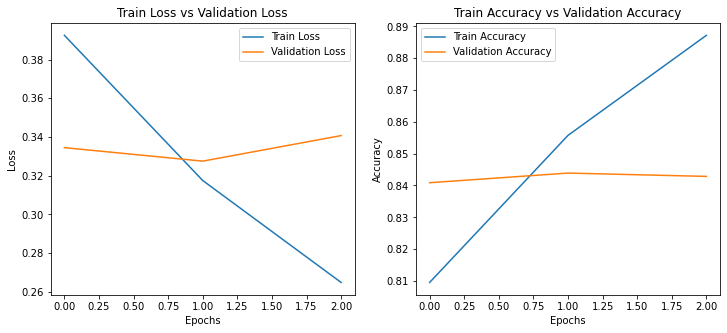

In [25]:
y_pred=model.predict(x_test_tf_cn)
ytrue = y_test.astype(int).tolist()
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
history.history['precision']=precision
history.history['recall']=recall
history.history['f1score']=f1score
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_CNN_TFIDF_V2_history.csv")
plot_loss_and_acc_from_hist2(hist_df)

In [26]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.8428595257290595
precision = 0.931404698800593
recall = 0.8340473460849976
f1score = 0.8800415954839188
[[19169  3054]
 [ 8251 41468]]
              precision    recall  f1-score   support

           0       0.70      0.86      0.77     22223
           1       0.93      0.83      0.88     49719

    accuracy                           0.84     71942
   macro avg       0.82      0.85      0.83     71942
weighted avg       0.86      0.84      0.85     71942



In [27]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_CNN_TFIDF_clasifctnrpt.csv")
df=pd.read_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_CNN_TFIDF_clasifctnrpt.csv")
df=df.set_index('Unnamed: 0')
df.index.rename(' ', inplace=True)
df.head()

,precision,recall,f1-score,support
,,,,
0,0.699088,0.862575,0.772274,22223.00000
1,0.931405,0.834047,0.880042,49719.00000
accuracy,0.842860,0.842860,0.842860,0.84286
macro avg,0.815246,0.848311,0.826158,71942.00000
weighted avg,0.859642,0.842860,0.846752,71942.00000


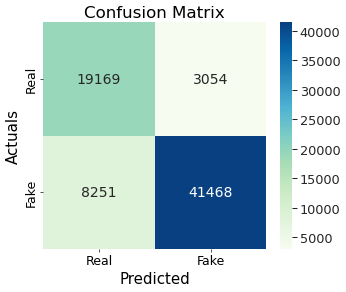

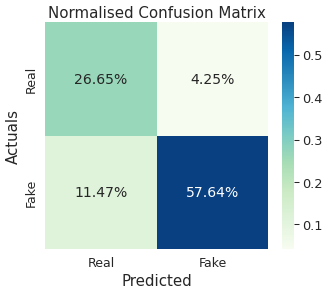

In [28]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_tfidf//fakeddit_cnn_tfidf_cmtrx.png"
path2="outputs//fakeddit_dl_tfidf//fakeddit_cnn_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Using LSTM

In [69]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "outputs//fakeddit_dl_tfidf//model_FAKEDDIT_LSTM_TFIDF_V2.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

In [70]:
lstm_model = Sequential(name = 'lstm_nn_model')
lstm_model.add(LSTM(512, input_shape=(1, max_features),return_sequences=True,dropout=0.2,recurrent_dropout=0.2))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(512, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(2e-5),metrics=['accuracy'])
lstm_model.summary()

Model: "lstm_nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            7194624   
                                                                 
 batch_normalization (BatchN  (None, 1, 512)           2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1, 512)            262656    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 512)           2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 dense_1 (Dense)             (None, 1, 64)           

In [71]:
clear_session()

In [72]:
warnings.filterwarnings('ignore')
history_lstm=lstm_model.fit(x_train_tf_dl, y_train, epochs=5, batch_size=32,
                            validation_split=0.2, callbacks=callbacks_list_lstm)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2499/2500 [============================>.] - ETA: 0s - loss: 0.5903 - accuracy: 0.6987WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b326efe0f28> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

#### Predictions

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 14s 6ms/step
Training Accuracy : 0.8138874769210815
Validation Accuracy : 0.824150025844574
Precision : 0.9242041198501872
Recall : 0.7941028580623102
F1 Score : 0.8542281937277557


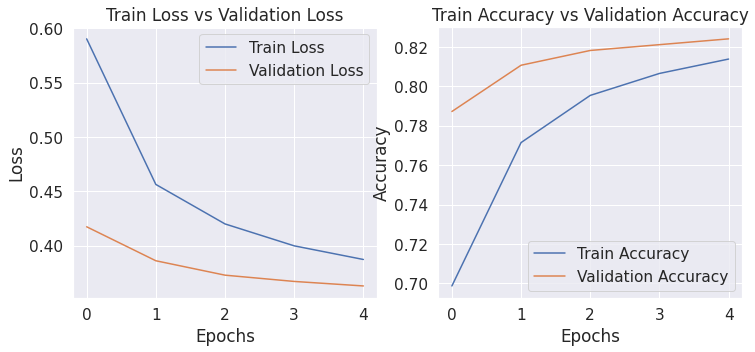

In [73]:
warnings.filterwarnings('ignore')
y_pred=lstm_model.predict(x_test_tf_dl)
ytrue = y_test.astype(int).tolist()
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
history_lstm.history['precision']=precision
history_lstm.history['recall']=recall
history_lstm.history['f1score']=f1score
hist_df = pd.DataFrame(history_lstm.history) 
hist_df.to_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_LSTM_TFIDF_V2_history.csv")
plot_loss_and_acc_from_hist2(hist_df)

In [74]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.8126963387173001
precision = 0.9242041198501872
recall = 0.7941028580623102
f1score = 0.8542281937277557
[[18985  3238]
 [10237 39482]]
              precision    recall  f1-score   support

           0       0.65      0.85      0.74     22223
           1       0.92      0.79      0.85     49719

    accuracy                           0.81     71942
   macro avg       0.79      0.82      0.80     71942
weighted avg       0.84      0.81      0.82     71942



In [75]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_LSTM_clasifctnrpt.csv")
df=pd.read_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_LSTM_clasifctnrpt.csv")
df=df.set_index('Unnamed: 0')
df.index.rename(' ', inplace=True)
df.head()

,precision,recall,f1-score,support
,,,,
0,0.649682,0.854295,0.738070,22223.000000
1,0.924204,0.794103,0.854228,49719.000000
accuracy,0.812696,0.812696,0.812696,0.812696
macro avg,0.786943,0.824199,0.796149,71942.000000
weighted avg,0.839404,0.812696,0.818347,71942.000000


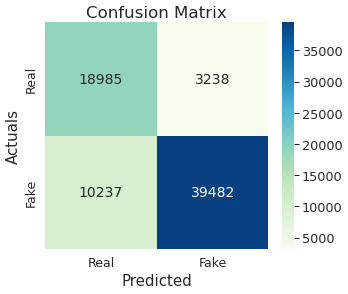

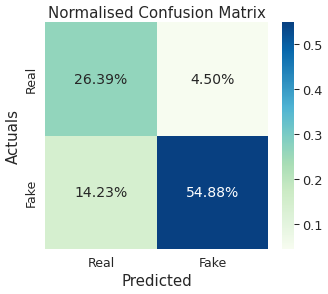

In [76]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_tfidf//fakeddit_lstm_tfidf_cmtrx.png"
path2="outputs//fakeddit_dl_tfidf//fakeddit_lstm_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

In [77]:
x_train_tf_dl.shape

(100000, 1, 3000)

## BiLSTM

In [78]:
filepath_bilstm = "outputs//fakeddit_dl_tfidf//model_FAKEDDIT_BILSTM_TFIDF_V2.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

In [79]:
bilstm_model = Sequential(name = 'bilstm_nn_model')

bilstm_model.add(Bidirectional(LSTM(512,input_shape=(1, max_features),return_sequences=True,
                                    dropout=0.2,recurrent_dropout=0.2)))

bilstm_model.add(BatchNormalization())
bilstm_model.add(Dense(512, activation='relu'))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(64, activation='relu'))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1,activation='sigmoid'))
bilstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(2e-5),metrics=['accuracy'])
#bilstm_model.build(input_shape=(1, max_features)) 
#bilstm_model.summary()

In [80]:
clear_session()

In [81]:
warnings.filterwarnings('ignore')
history_bilstm=bilstm_model.fit(x_train_tf_dl, y_train, epochs=5, batch_size=32,
                            validation_split=0.2, callbacks=callbacks_list_bilstm)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2500/2500 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7182WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b32b858f400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

#### Prediction

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 20s 9ms/step
Training Accuracy : 0.8321124911308289
Validation Accuracy : 0.8305000066757202
Precision : 0.9123622099011637
Recall : 0.8373458838673344
F1 Score : 0.8732459360251704


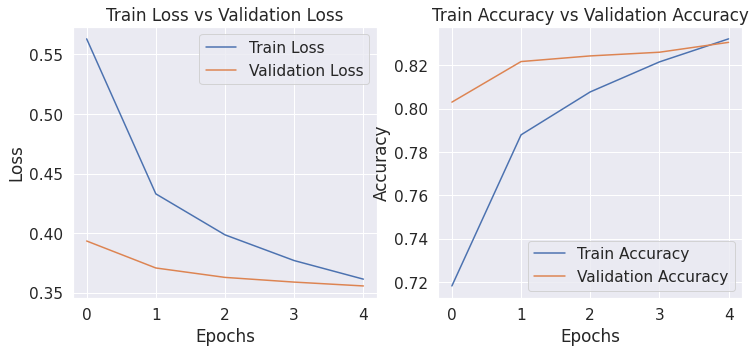

In [82]:
warnings.filterwarnings('ignore')
y_pred=bilstm_model.predict(x_test_tf_dl)
ytrue = y_test.astype(int).tolist()
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
history_bilstm.history['precision']=precision
history_bilstm.history['recall']=recall
history_bilstm.history['f1score']=f1score
hist_df = pd.DataFrame(history_bilstm.history) 
hist_df.to_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_BILSTM_TFIDF_V2_history.csv")
plot_loss_and_acc_from_hist2(hist_df)

In [83]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.8320035584220622
precision = 0.9123622099011637
recall = 0.8373458838673344
f1score = 0.8732459360251704
[[18224  3999]
 [ 8087 41632]]
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     22223
           1       0.91      0.84      0.87     49719

    accuracy                           0.83     71942
   macro avg       0.80      0.83      0.81     71942
weighted avg       0.84      0.83      0.84     71942



In [84]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_BILSTM_clasifctnrpt.csv")
df=pd.read_csv("outputs//fakeddit_dl_tfidf//model_FAKEDDIT_BILSTM_clasifctnrpt.csv")
df=df.set_index('Unnamed: 0')
df.index.rename(' ', inplace=True)
df.head()

,precision,recall,f1-score,support
,,,,
0,0.692638,0.820051,0.750979,22223.000000
1,0.912362,0.837346,0.873246,49719.000000
accuracy,0.832004,0.832004,0.832004,0.832004
macro avg,0.802500,0.828699,0.812112,71942.000000
weighted avg,0.844489,0.832004,0.835477,71942.000000


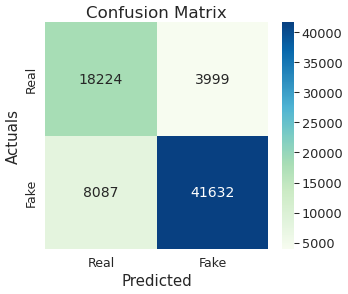

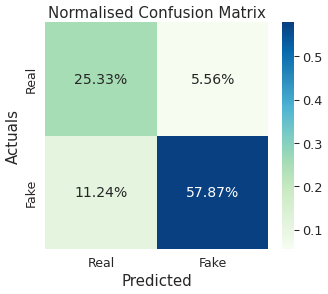

In [85]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_tfidf//fakeddit_bilstm_tfidf_cmtrx.png"
path2="outputs//fakeddit_dl_tfidf//fakeddit_bilstm_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)